### Customer Segmentation with RFM - Online Retail Dataset

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# checking missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# dropping rows with no customerID
df=df.dropna(subset=['CustomerID'])

In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
# check and remove duplicate entries
df.duplicated().sum()

5225

In [10]:
df=df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

In [12]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

##### RFM
The RFM values can be grouped in several ways. We will use percentiles e.g. quantiles

In [14]:
df['TotalSum'] = df['Quantity']*df['UnitPrice']

In [15]:
# date from which we will calculate number of days since last purchase
lookup_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
lookup_date

Timestamp('2011-12-10 12:50:00')

In [16]:
rfm_metrics = df.groupby('CustomerID').agg({'InvoiceDate': lambda x : (lookup_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})

rfm_metrics.rename(columns={'InvoiceDate':'Recency',\
                              'InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)
rfm_metrics

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [17]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm_metrics['Recency'], q = 4, labels = r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm_metrics['Frequency'], q = 4, labels = f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm_metrics['MonetaryValue'], q = 4, labels = m_labels)

In [18]:
rfm_metrics = rfm_metrics.assign(R=r_groups,F=f_groups,M=m_groups)

In [19]:
rfm_metrics['RFM_Segment'] = rfm_metrics.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm_metrics['RFM_Score'] = rfm_metrics[['R', 'F', 'M']].sum(axis = 1)
rfm_metrics.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


In [20]:
rfm_metrics.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

##### Data Pre-Processing for Kmeans Clustering
We must check these Key k-means assumptions before we implement our Kmeans Clustering Mode

- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

In [21]:
rfm_df = rfm_metrics[['Recency', 'Frequency', 'MonetaryValue']]
rfm_df.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


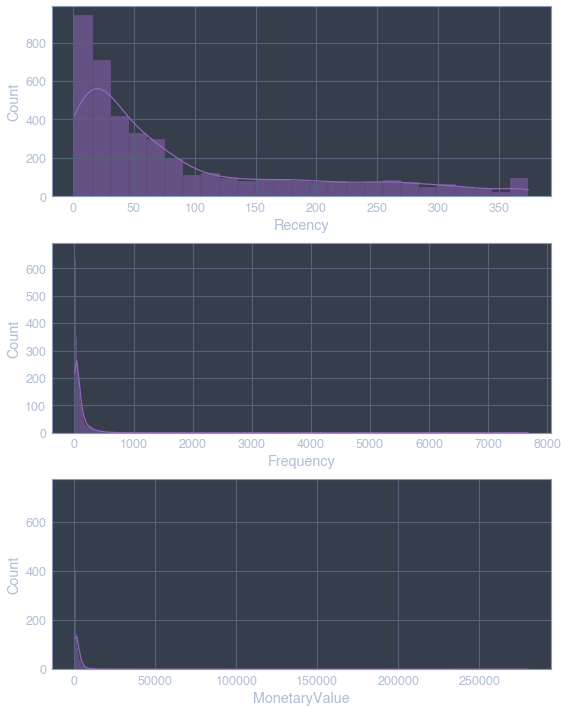

In [22]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(8, 10))
plt.subplot(3, 1, 1);sns.histplot(rfm_df['Recency'], label = 'Recency', color='tab:purple',kde=True)
plt.subplot(3, 1, 2);sns.histplot(rfm_df['Frequency'], label = 'Frequency',color='tab:purple',kde=True)
plt.subplot(3, 1, 3);sns.histplot(rfm_df['MonetaryValue'], label = 'Monetary Value',color='tab:purple',kde=True)
plt.tight_layout()
plt.show();


In [23]:
# Unskew data with log transformation before scalling the data

rfm_log=rfm_df[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)


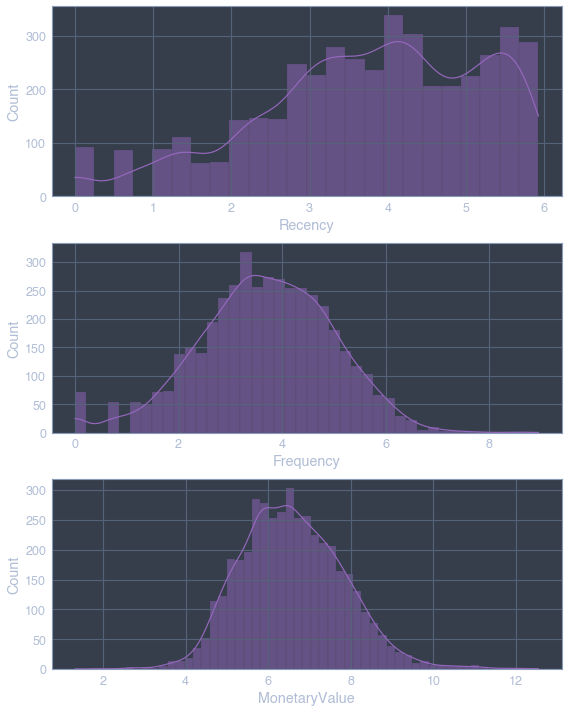

In [24]:
f,ax = plt.subplots(figsize=(8, 10))
plt.subplot(3, 1, 1);sns.histplot(rfm_log['Recency'], label = 'Recency',color='tab:purple',kde=True)
plt.subplot(3, 1, 2);sns.histplot(rfm_log['Frequency'], label = 'Frequency',color='tab:purple',kde=True)
plt.subplot(3, 1, 3);sns.histplot(rfm_log['MonetaryValue'], label = 'Monetary Value',color='tab:purple',kde=True)
plt.tight_layout()
plt.show();

##### Implementation of K-Means Clustering
###### Key steps

- Data pre-processing
- Choosing a number of clusters
- Running k-means clustering on pre-processed data
- Analyzing average RFM values of each cluster

In [25]:
#Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

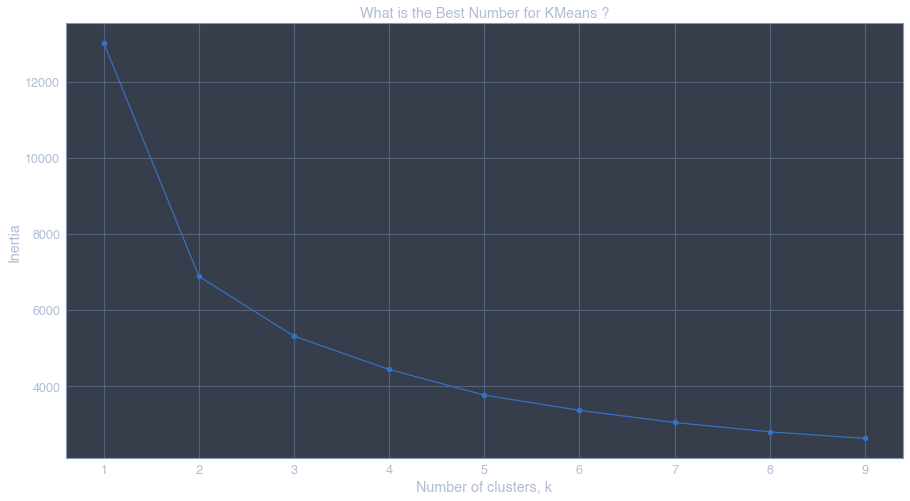

In [26]:
# find a good number of clusters with elbow method
k_size = range(1,10)
inertias=[]
for k in k_size :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(k_size, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_size)
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [28]:
# we choose 3 clusters as 2 give us less information
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_segmentation = rfm_df.assign(Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_segmentation.groupby('Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         171.0      15.0         293.0  1522
1          13.0     259.0        6536.0   961
2          69.0      65.0        1164.0  1855

In [29]:
# snakeplots
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_df.index,columns=rfm_df.columns)
rfm_normalized['Cluster'] = kc.labels_
rfm_normalized.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized,id_vars=['CustomerID','Cluster'],value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346.0,2,Recency,1.409982
1,12347.0,1,Recency,-2.146578
2,12348.0,2,Recency,0.383648
3,12349.0,2,Recency,-0.574961
4,12350.0,0,Recency,1.375072


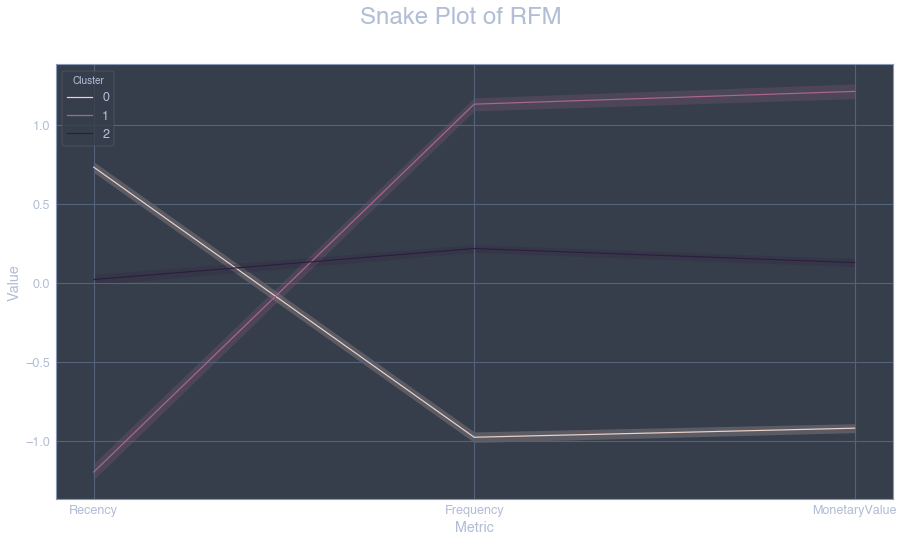

In [30]:
f, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x = 'Metric', y = 'Value', hue = 'Cluster', data = rfm_melt,ax=ax)

plt.suptitle("Snake Plot of RFM",fontsize=24)
plt.show();